In [84]:
import json
import sys
from urllib.parse import urlparse

import pandas as pd
import torch
from PIL import Image
from clickhouse_driver import Client
from torch import nn
from tqdm.auto import tqdm

sys.path.append("../")

tqdm.pandas()


class ClickHouse:
    def __init__(self, client: Client):
        self.client = client
        self.json = {}
        self.image_weigth = 0.6
        self.name_weight = 0.2
        self.tags_weight = 0.2

    def preprocess_images_df(self, images_df, embeddings):
        num_samples = 0  # self.get_num_samples()
        images_df["id"] = [num_samples + k for k in range(0, images_df.shape[0])]
        images_df["embedding"] = embeddings.tolist()
        images_df["path"] = images_df["path"]
        images_df.to_json("images+embeddings.json")

        file_path = "images+embeddings.json"

        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)

        ids = data["id"]
        embeddings = data["embedding"]
        paths = data["path"]

        rows_to_insert = []
        for i in range(len(ids)):
            i_str = str(i)

            row = {
                "id": ids[i_str],
                "path": paths[i_str],
                "embedding": embeddings[i_str],
            }
            rows_to_insert.append(row)

        return rows_to_insert

    def _post_process_images(self, samples):
        samples = list(map(list, samples))
        return samples

    # def build_json(self, )
    def add(self, json):
        # print(df)
        # insert_info = self.preprocess_images_df(json)
        # print(insert_info)
        """
        json = {
            "id": id,
            "img_url": img_url,
            "image_embedding": image_embedding,
            "name_embedding": name_embedding,
            "tags_embedding": tags_embedding,
            "embedding": embedding,
            "tags": tags,
            "orientation_filter": orientation_filter,
            "extention_filter": extention_filter,
            "daytime_filter": daytime_filter,
            "season_filter": season_filter,
            "hidden": False
        }
        """

        # print(json)

        self.client.execute(
            "INSERT INTO images_embeddings_db (id, img_url, image_embedding, name_embedding, tags_embedding, embedding, tags, orientation_filter, extension_filter, daytime_filter, season_filter, hidden) VALUES",
            [json],
        )

    def _click_to_pd_images(self, click_out):
        # print(click_out)
        df = pd.DataFrame(columns=["id", "path", "cos"], data=click_out)
        return df

    def retrieve(self, embedding, filters, query_by: str = "embedding", table: str = 'misis.images_embeddings_db',
                 order_by="score", k: int = 1):

        """
            SELECT
            id,
            img_url,
            cosineDistance({query_by}, {str(embedding[0].tolist())}) AS score
            FROM {table}

            SELECT *
            WHERE
        (orientation_filter IS vertical) AND (extension_filter IS jpg) AND (daytime_filter IS вечер) AND (season_filter IS лето)
            ORDER BY score ASC
            LIMIT 100
            FORMAT Vertical

        """

        request = f"""SELECT
            subquery.id,
            subquery.img_url,
            name,
            cosineDistance(subquery.{query_by}, {str(embedding[0].tolist())}) AS score
        FROM (
            SELECT *
            FROM {table}
            WHERE {" AND ".join([f"{key} = '{filters[key]}'" for key in filters])} AND hidden = False
        ) AS subquery
        ORDER BY {order_by} ASC
        LIMIT 100
        FORMAT Vertical
        """

        # request = filt + sort_and_limit
        # print(request)

        result = self.client.execute(request)
        df = self._click_to_pd_images(result)

        return df

    def check_duplicates(self, embedding):
        request = f"""SELECT
            id,
            img_url,
            cosineDistance(image_embedding, {str(embedding[0].tolist())}) AS score
            FROM misis.images_embeddings_db
            WHERE hidden = False
            ORDER BY score ASC
            LIMIT 1
            FORMAT Vertical
        """

        result = self.client.execute(request)
        df = self._click_to_pd_images(result)

        return df

    def edit(self, json):
        data = json
        update_base = "ALTER TABLE misis.images_embeddings_db UPDATE "
        updates = []

        if data["name_embedding"] is not None:
            data["name_embedding"] = data["name_embedding"][0].tolist()

        if data["tags_embedding"] is not None:
            data["tags_embedding"] = data["tags_embedding"][0].tolist()

        # print(json, "OUTPUT")

        for key, value in data.items():
            if key != 'id' and value is not None:
                updates.append(f"{key} = '{value}'")

        if not updates:
            # print("Нет данных для обновления.")
            pass
        else:
            update_query = update_base + ", ".join(updates) + f" WHERE id = {data['id']}"
            # print("Сформированный SQL запрос:", update_query)

            self.client.execute(update_query)

        self.recalculate_embedding(data['id'])

    def recalculate_embedding(self, id):
        request = f"""SELECT
            image_embedding,
            name_embedding,
            tags_embedding,
            FROM misis.images_embeddings_db
            WHERE id = {id}
        """

        image_embedding, name_embedding, tags_embedding = [torch.tensor(embedding) for embedding in
                                                           self.client.execute(request)[0]]

        embedding = self.image_weigth * image_embedding + self.name_weight * name_embedding + self.tags_weight * tags_embedding

        update = f"""
            ALTER TABLE misis.images_embeddings_db UPDATE 
            embedding = {embedding.tolist()}
            WHERE id = {id}
        """

        self.client.execute(update)

    def hide_sample(self, id):
        update = f"""
            ALTER TABLE misis.images_embeddings_db UPDATE 
            hidden = True
            WHERE id = {id}
        """

        self.client.execute(update)

    def recover_sample(self, id):
        update = f"""
            ALTER TABLE misis.images_embeddings_db UPDATE 
            hidden = False
            WHERE id = {id}
        """

        self.client.execute(update)

    def get_num_samples(self, table: str = "misis.images_embeddings_db"):
        request = f"""
        SELECT COUNT() FROM {table};
        """

        return self.client.execute(request)[0][0]


class Retriever:
    def __init__(
            self,
            model,
            processor,
            tagger,
            translator,
            ood_model,
            clickhouse: ClickHouse,
            image_weigth: float = 0.6,
            name_weight: float = 0.2,
            tags_weight: float = 0.2,
            device: str = "cuda",
    ):
        super().__init__()
        self.device = device

        self.model = model
        self.model.eval()
        self.model.to(self.device)
        self.processor = processor
        self.tagger = tagger
        self.translator = translator
        self.ood_model = ood_model

        self.image_weigth = image_weigth
        self.name_weight = name_weight
        self.tags_weight = tags_weight

        self.clickhouse = clickhouse

        self.cos = nn.CosineSimilarity()

        self.seasons = ["зима", "весна", "лето", "осень"]
        self.daytimes = ["утро", "день", "вечер", "ночь"]
        self.season_embeddings = self.normalize_embedding(self.get_text_latents(self.seasons))
        self.daytime_embeddings = self.normalize_embedding(self.get_text_latents(self.daytimes))

    @torch.inference_mode()
    def get_text_latents(self, texts):
        text_latents = []

        inputs = self.processor(text=texts, return_tensors='pt', padding=True)
        text_latents.append(self.model.encode_text(inputs['input_ids'].to(self.device)))

        text_latents.append(torch.cat(text_latents, dim=0))
        text_latents = torch.stack(text_latents).mean(0)

        return text_latents

    @torch.inference_mode()
    def get_image_latents(self, images):
        image_latents = []

        inputs = self.processor(text='', images=images, return_tensors='pt', padding=True)
        image_latents.append(self.model.encode_image(inputs['pixel_values'].to(self.device)))

        image_latents = torch.cat(image_latents)

        return image_latents

    @staticmethod
    def normalize_embedding(embedding):
        return embedding / embedding.norm(dim=-1, keepdim=True)

    @staticmethod
    def _paths_to_images(path):
        image = Image.open(path)
        return image

    def add(self, id, img_url, name, return_json: bool = True):
        image = self._paths_to_images(img_url)

        image_embedding = self.normalize_embedding(self.get_image_latents([image]))
        name_embedding = self.normalize_embedding(self.get_text_latents([name]).cpu())
        filters = self.get_filters(img_url, image, image_embedding)
        orientation_filter, extention_filter, daytime_filter, season_filter = filters

        image_embedding = image_embedding.cpu()

        tags = self.get_tags(image)
        joined_tags = self.join_tags(tags)
        tags_text = self.translate(joined_tags)
        tags_embedding = self.normalize_embedding(self.get_text_latents([tags_text]).cpu())
        # print(filters)

        embedding = self.image_weigth * image_embedding + self.name_weight * name_embedding + self.tags_weight * tags_embedding

        dupl_df = self.find_duplicates(image_embedding)
        dupl_df = dupl_df[dupl_df["cos"] < 0.15]
        dupl_ids = dupl_df["id"].tolist()

        torch.cuda.empty_cache()

        json = {
            "id": id,
            "img_url": img_url,
            "image_embedding": image_embedding[0].tolist(),
            "name_embedding": name_embedding[0].tolist(),
            "tags_embedding": tags_embedding[0].tolist(),
            "embedding": embedding[0].tolist(),
            "tags": tags,
            "orientation_filter": orientation_filter,
            "extension_filter": extention_filter,
            "daytime_filter": daytime_filter,
            "season_filter": season_filter,
            "hidden": False
        }

        self.clickhouse.add(json)

        return dupl_ids

    def edit(self, id, name=None, tags: list = None, input_filters: dict = None):
        json = {
            "id": id,
            "img_url": None,
            "image_embedding": None,
            "name_embedding": None,
            "tags_embedding": None,
            "embedding": None,
            "tags": None,
            "orientation_filter": None,
            "extention_filter": None,
            "daytime_filter": None,
            "season_filter": None,
            "hidden": False
        }
        if name:
            json['name_embedding'] = self.normalize_embedding(self.get_text_latents([name]).cpu())

        if tags:
            # json['tags'] = tags
            json['tags_embedding'] = self.normalize_embedding(self.get_text_latents([" ".join(tags)]).cpu())
        # orientation, extension, daytime, season

        if input_filters:
            if input_filters['orientation']:
                json['orientation_filter'] = input_filters['orientation']
            if input_filters['extension']:
                json['extension_filter'] = input_filters['extension']
            if input_filters['daytime']:
                json['daytime_filter'] = input_filters['daytime']
            if input_filters['season']:
                json['season_filter'] = input_filters['season']

        # filters = self.get_filters(img_url, image, image_embedding)
        # orientation_filter, extension_filter, daytime_filter, season_filter = filters

        # tags = self.get_tags(image)
        # tags_embedding = get_text_latens([tags])
        # print(filters)

        torch.cuda.empty_cache()

        self.clickhouse.edit(json)

    @staticmethod
    def get_orientation_filter(image):
        H, W = image.height, image.width

        if H > W:
            return "vertical"
        elif H < W:
            return "horizontel"
        else:
            return "square"

    def get_extention_filter(self, img_url):
        extension = urlparse(img_url).path.strip("/").rsplit(".", 1)[-1]
        return extension

    def get_daytime_filter(self, img_latent):
        scores = self.cos(img_latent.cpu(), self.daytime_embeddings.cpu()).softmax(dim=0)
        ind = scores.argmax(dim=0).item()
        return self.daytimes[ind]

    def get_season_filter(self, img_latent):
        scores = self.cos(img_latent.cpu(), self.season_embeddings.cpu()).softmax(dim=0)
        ind = scores.argmax(dim=0).item()
        return self.seasons[ind]

    def get_filters(self, img_url, image, img_latents):
        orientation_filter = self.get_orientation_filter(image)
        extention_filter = self.get_extention_filter(img_url)
        daytime_filter = self.get_daytime_filter(img_latents)
        season_filter = self.get_season_filter(img_latents)

        return orientation_filter, extention_filter, daytime_filter, season_filter

    def get_tags(self, image):
        tags = self.tagger(image)
        return tags

    @staticmethod
    def join_tags(tags):
        return " ".join(tags)

    def translate(self, text):
        return self.translator(text, "en", "ru")

    def detect_and_translate(self, text):
        source_lang = self.translator.detect_lang(text)
        return self.translator.translate(text, source_lang, "ru")

    def find_duplicates(self, image_embedding):
        return self.clickhouse.check_duplicates(image_embedding)

    def check_ood(self, text, tags):
        text = self.detect_and_translate(text)
        tags = self.detect_and_translate(self.join_tags(tags))

        text_embedding = self.get_text_latents([text]).cpu().numpy()
        tags_embedding = self.get_text_latents([tags]).cpu().numpy()

        text_ood_score = self.ood_model.predict(text_embedding).item()
        tags_ood_score = self.ood_model.predict(tags_embedding).item()

        return text_ood_score or tags_ood_score

    def hide_sample(self, id):
        self.clickhouse.hide_sample(id)

    def recover_sample(self, id):
        self.clickhouse.recover_sample(id)

    def query(self, img_url: str = None, text: str = None, tags: list = None, filters: dict = None, k: int = 1):
        """
        filters = {
            "orientation_filter": orientation_filter,
            "extension_filter": extention_filter,
            "daytime_filter": daytime_filter,
            "season_filter": season_filter,
        }
        """

        if img_url is not None:
            image = self._paths_to_images(img_url)
            image_embedding = self.normalize_embedding(self.get_image_latents([image]))
            retrieved = self.clickhouse.retrieve(image_embedding, filters, query_by="image_embedding", k=k)

        else:
            if text is not None and tags is None:
                text = self.detect_and_translate(text)

                text_embedding = self.normalize_embedding(self.get_text_latents([text]))
                retrieved = self.clickhouse.retrieve(text_embedding, filters, query_by="embedding", k=k)

            elif tags is not None and text is None:
                tags = self.join_tags(tags)
                tags = self.detect_and_translate(tags)
                tags_embedding = self.normalize_embedding(self.get_text_latents([tags]))
                retrieved = self.clickhouse.retrieve(tags_embedding, filters, query_by="embedding", k=k)

            elif tags is not None and text is not None:
                text = self.detect_and_translate(text)
                tags = self.join_tags(tags)
                tags = self.detect_and_translate(tags)

                tags_embedding = self.normalize_embedding(self.get_text_latents([tags]))
                text_embedding = self.normalize_embedding(self.get_text_latents([text]))

                embedding = (text_embedding + tags_embedding) / 2
                retrieved = self.clickhouse.retrieve(embedding, filters, query_by="embedding", k=k)

            else:
                raise ValueError("Either img_url of text or tags or filters should not be equal to None")

        torch.cuda.empty_cache()
        return retrieved

    def __len__(self):
        return self.clickhouse.get_num_samples()


In [85]:
import os
import sys

import ruclip
import nltk
from clickhouse_driver import Client
from fastapi import FastAPI
from tqdm.auto import tqdm

sys.path.append("../")

from translation_service.translation import Translator
from blip_tagging import Tagger
from ood import OOD
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

In [86]:
link = "https://01b3-109-252-98-213.ngrok-free.app"

translator = Translator(link)

In [87]:
clickhouse = ClickHouse(client=Client(host='158.160.153.233', port=9000,  password='JX2J59Y4g29A', user='misis_admin', database='misis'))

In [88]:
import nltk
nltk.download('stopwords')

tagger = Tagger("Salesforce/blip-image-captioning-large")

[nltk_data] Downloading package stopwords to /home/leffff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
import ruclip

device = 'cuda'
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', cache_dir='/tmp/ruclip', device=device)

In [90]:
ood_model = OOD(
    "catboost_ood",
    threshold=0.675
)

In [91]:
retriever = Retriever(
    model=clip,
    processor=processor,
    clickhouse=clickhouse,
    tagger=tagger,
    translator=translator,
    ood_model=ood_model
)

# Детекция нерелевантных/нецензурных запросов

In [94]:
retriever.check_ood("Эротические изображения", ["хуй"])

True

# Удаление/добавление семплов

In [25]:
retriever.hide_sample(0)

In [26]:
retriever.recover_sample(0)

# Добавление в БД

In [27]:
DATA = "../../dataset/"

paths = [file for file in os.listdir(DATA)]
df = pd.DataFrame({"path": paths})
df["path"] = DATA + df["path"] 
df

,path
0,../../dataset/Новодевичий монастырь_7.jpg
1,../../dataset/Храм Христа Спасителя_1.jpg
2,"../../dataset/Тверская, 13.jpg"
3,../../dataset/Сокол_станция метро.jpg
4,../../dataset/Зарядье_7.jpg
...,...
499,../../dataset/Царицыно_11.jpg
500,../../dataset/Москва-Сити_2.jpg
501,../../dataset/Шуховская Башня.jpg
502,../../dataset/Успенский собор_1.jpg


In [28]:
df["name"] = df["path"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])
df

,path,name
0,../../dataset/Новодевичий монастырь_7.jpg,Новодевичий монастырь
1,../../dataset/Храм Христа Спасителя_1.jpg,Храм Христа Спасителя
2,"../../dataset/Тверская, 13.jpg","Тверская, 13"
3,../../dataset/Сокол_станция метро.jpg,Сокол
4,../../dataset/Зарядье_7.jpg,Зарядье
...,...,...
499,../../dataset/Царицыно_11.jpg,Царицыно
500,../../dataset/Москва-Сити_2.jpg,Москва-Сити
501,../../dataset/Шуховская Башня.jpg,Шуховская Башня
502,../../dataset/Успенский собор_1.jpg,Успенский собор


In [ ]:
%%time

for i in tqdm(range(50)):
    path, name = df["path"].tolist()[i], df["name"].tolist()[i]
    id = i
    
    retriever.add(
        id=id,
        img_url=path,
        name=name,
        return_json=False
    )

  4%|██████████▍                                                                                                                                                                                                                                                          | 2/50 [00:11<04:44,  5.92s/it]

In [60]:
retriever.add(
    id=id,
    img_url=path,
    name=name,
    return_json=False
)

[14, 14]

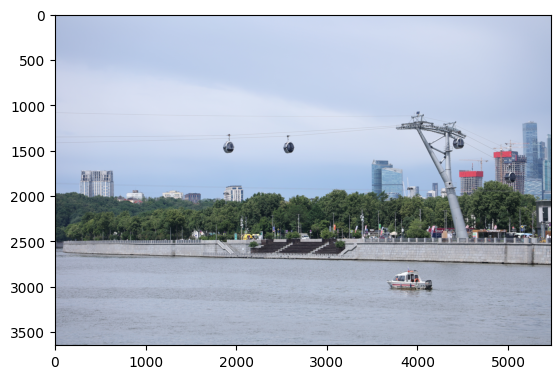

In [16]:
raw_image = Image.open(path)
plt.imshow(raw_image)

# Редактировать семпл

In [17]:
%%time

retriever.edit(
    id=2,  
    name="Какая-то башня", 
    tags=["Озеро", "башни", "деревья"],
    input_filters = {'daytime': 'утро', 'season': 'осень', 'orientation': 'vertical', 'extension': 'jpg'}
)

Сформированный SQL запрос: ALTER TABLE misis.images_embeddings_db UPDATE name_embedding = '[0.07870384305715561, 0.031724438071250916, -0.03136417269706726, -0.02644212171435356, -0.030564293265342712, -0.04554649814963341, -0.00019871487165801227, 0.10622170567512512, 0.025606749579310417, -0.029552830383181572, -0.023958414793014526, -0.03634066879749298, 0.0033003066200762987, -0.055715419352054596, 0.0006506970385089517, 0.0013969389256089926, 0.030212655663490295, -0.015554575249552727, 0.04487672448158264, -0.010883158072829247, 0.001763613079674542, 0.09900397062301636, 0.011438603512942791, 0.02456088177859783, 0.03769860044121742, 0.004862066358327866, 0.0142067177221179, 0.07885180413722992, 0.009318480268120766, -0.03622322902083397, 0.0795903354883194, 0.12099071592092514, -0.033404938876628876, 0.007407378405332565, -0.09445219486951828, -0.021404005587100983, 0.017321722581982613, 0.03829601779580116, 0.03147347271442413, 0.10263636708259583, 0.04455382749438286, 0.002800

# Поиск по бд

In [18]:
path

'../../dataset/Московская канатная дорога_1.JPG'

In [24]:
%%time

filters = {
            "orientation_filter": "vertical",
            "extension_filter": "jpg",
            "daytime_filter": "вечер",
            "season_filter": "лето",
        }

retrieved = retriever.query(
    # img_url=path,
    text="Новодевичий монастырь", 
    # tags=["башни", "мост", "деревья"],
    filters=filters,
    k=10
)
retrieved

CPU times: user 10.3 ms, sys: 25.8 ms, total: 36.1 ms
Wall time: 2.64 s


,id,path,cos
0,0,../../dataset/Новодевичий монастырь_7.jpg,0.339581
1,11,../../dataset/Чистые пруды.jpg,0.665819
2,7,../../dataset/Дом на Беговой.jpg,0.742576
3,12,../../dataset/Водоотводный канал.jpg,0.759151


In [26]:
%%time

filters = {
            "orientation_filter": "vertical",
            "extension_filter": "jpg",
            "daytime_filter": "вечер",
            "season_filter": "лето",
        }

retrieved = retriever.query(
    # img_url=path,
    text="Дом на Беговой", 
    # tags=["башни", "мост", "деревья"],
    filters=filters,
    k=10
)
retrieved

CPU times: user 16 ms, sys: 18.5 ms, total: 34.5 ms
Wall time: 5.5 s


,id,path,cos
0,7,../../dataset/Дом на Беговой.jpg,0.437851
1,12,../../dataset/Водоотводный канал.jpg,0.723511
2,0,../../dataset/Новодевичий монастырь_7.jpg,0.764345
3,11,../../dataset/Чистые пруды.jpg,0.764692


In [83]:
%%time

filters = {
            "orientation_filter": "vertical",
            "extension_filter": "jpg",
            "daytime_filter": "вечер",
            "season_filter": "лето",
        }

retrieved = retriever.query(
    # img_url=path,
    text="Водоотводный канал", 
    tags=["башни", "мост", "деревья"],
    filters=filters,
    k=10
)
retrieved

CPU times: user 27.4 ms, sys: 16.8 ms, total: 44.2 ms
Wall time: 13.2 s


,id,path,cos
0,12,../../dataset/Водоотводный канал.jpg,0.546072
1,12,../../dataset/Водоотводный канал.jpg,0.546072
2,28,../../dataset/Якиманская набережная_2.jpg,0.615111
3,11,../../dataset/Чистые пруды.jpg,0.662627
4,11,../../dataset/Чистые пруды.jpg,0.662627
5,0,../../dataset/Новодевичий монастырь_7.jpg,0.677340
6,0,../../dataset/Новодевичий монастырь_7.jpg,0.677340
7,7,../../dataset/Дом на Беговой.jpg,0.794571
8,7,../../dataset/Дом на Беговой.jpg,0.794571


1 церковь 
0 тверская 
1 кремль
1 москва сити
1 василия блаженного
1 лужники
1 патриаршие пруды
1 водоотводный канал
1 поселок художников
0 эрмитаж
1 ГУМ
1 ГУМ Каток
1 Парк Горького
1 Новодевичий монастырь
0 Дизайн завод
1 ДЕПО
1 Северный речной вокзал
1 Красный октябрь
1 Здание мин сельхоза
0 АРМА
1 МХТ
1 Планетарий
1 Поклонная гора
1 ВДНХ
0 Дом купца игумнова
0 Дом перова

# Детекция дубликатов

In [20]:
low_res_raw_image = raw_image.resize((128, 128))

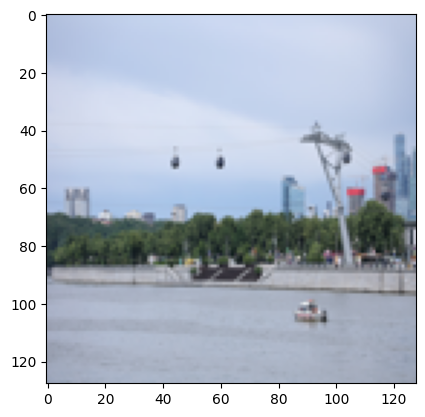

In [21]:
plt.imshow(low_res_raw_image)

In [22]:
dupl_path = retriever.find_duplicates(retriever.get_image_latents([raw_image]))["path"][0]
dupl_path

'../../dataset/Московская канатная дорога_1.JPG'

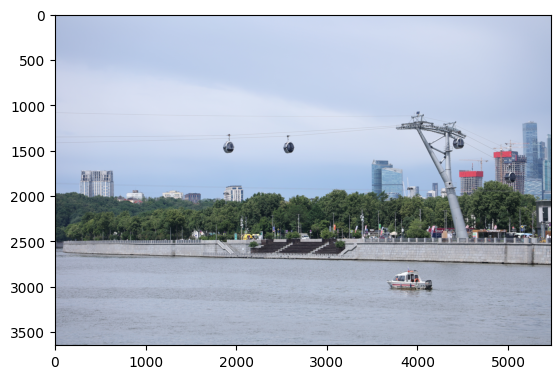

In [23]:
plt.imshow(Image.open(dupl_path))